# Температура нагрева стали после обработки

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель исследования** —  построить модель, которая на основании параметров процесса обработки стали будет предсказывать итоговую температуру материала.

Для оценки качества модели выбрана метрика `MAE` (среднее абсолютное отклонение), модель будем считать успешной, если значение метрики на тестовой выборке будет менее 6,8.

**Ход исследования**

Нам предоставлено 7 файлов:
* `data_arc.csv` — данные об электродах;
* `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
* `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
* `data_gas.csv` — данные о продувке сплава газом;
* `data_temp.csv` — результаты измерения температуры;
* `data_wire.csv` — данные о проволочных материалах (объём);
* `data_wire_time.csv` — данные о проволочных материалах (время).

О качестве данных ничего не известно. Поэтому перед проведением исследования потребуется подготовка данных, в рамках которой мы выполним обзор и предобработку данных.
  
Следующим этапом мы проведем исследовательский анализ данных, попытаемся вникнуть в суть, проверим данные на наличие аномалий и попытаемся выявить взаимосвязи. Здесь стоит отметить, что по информации от заказчика в данных есть 2 аномалии, это сильно отрицательная мощность и температура менее 1500 градусов, наблюдения с этими аномалиями не нужно использовать для построения модели. 

После нам необходимо будет подготовить данные для дальнейшего построения моделей машинного обучения, нам нужно будет выделить и отобрать признаки.

Далее мы перейдем к построению моделей. В первую очередь нам нужно будет выделить тестовую выборку в размере 25% от имеющегося в нашем распоряжении набора данных. После на выделенной тренировочной выборке мы обучим модели различных типов, оценку моделей будем производить с помощью метода кросс-валидации. Для оценки адекватности моделей также построим наивную модель.

Для обучения предполагается использовать следующие модели:
* `LinearRegressor` - алгоритм для построения линейной регрессии
* `CatBoostRegressor` - модель, использующая алгоритм градиентного спуска
* `RandomForestRegressor` - алгоритм случайного леса, использующий ансамбли решающих деревьев.

Заключительным этапом нашего исследования будет выбор наилучшей модели и её проверка на тестовой выборке, после чего мы сможем сделать окончательные выводы и предоставить рекомендации.
 
Таким образом, исследование пройдёт в несколько этапов:
 * **Подготовка данных**
     * обзор данных
     * первичная предобработка
 * **Исследовательский анализ**
     * расчёт дополнительных измерений
     * выявление аномалий в данных
     * поиск взаимосвязей
 * **Подготовка данных для обучения**
     * выделение признаков
     * построение корреляционной матрицы
     * отбор признаков
 * **Обучение моделей**
     * разделение на обучающую и тренировочную выборки
     * обучение моделей
 * **Выбор лучшей модели и тестирование**
 * **Отчёт**

## Подготовка данных

In [45]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from phik.report import plot_correlation_matrix

from catboost import CatBoostRegressor, Pool

import warnings
warnings.simplefilter(action='ignore')

sns.set_style("darkgrid")

In [46]:
RANDOM_STATE = 270323
CV_COUNT = 5

### Загрузка и обзор данных

Загрузим исходные датасеты и сохраним их в один объект типа `dict` для удобства проведения дальнейшего анализа и преобразований.

In [47]:
path = '/datasets/final_steel/'
files_list = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']
data_dict = {i: pd.read_csv(path + i + '.csv') for i in files_list}

In [48]:
for name, df in data_dict.items():
    print('—'*80, '\nДатасет ', name,'\n','—'*80 ,sep='')
    print(name, ' dataset info:\n', sep='')
    df.info()
    print('\n',name, ' dataset head:', sep='')
    display(df.head())
    print(name, ' dataset describe:', sep='')
    display(df.describe().T)
    print()

————————————————————————————————————————————————————————————————————————————————
Датасет data_arc
————————————————————————————————————————————————————————————————————————————————
data_arc dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

data_arc dataset head:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


data_arc dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388



————————————————————————————————————————————————————————————————————————————————
Датасет data_bulk
————————————————————————————————————————————————————————————————————————————————
data_bulk dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dty

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


data_bulk dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0



————————————————————————————————————————————————————————————————————————————————
Датасет data_bulk_time
————————————————————————————————————————————————————————————————————————————————
data_bulk_time dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


data_bulk_time dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0



————————————————————————————————————————————————————————————————————————————————
Датасет data_gas
————————————————————————————————————————————————————————————————————————————————
data_gas dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

data_gas dataset head:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


data_gas dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504



————————————————————————————————————————————————————————————————————————————————
Датасет data_temp
————————————————————————————————————————————————————————————————————————————————
data_temp dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

data_temp dataset head:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


data_temp dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0



————————————————————————————————————————————————————————————————————————————————
Датасет data_wire
————————————————————————————————————————————————————————————————————————————————
data_wire dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

data_wire dataset head:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


data_wire dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604



————————————————————————————————————————————————————————————————————————————————
Датасет data_wire_time
————————————————————————————————————————————————————————————————————————————————
data_wire_time dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

data_wire_time dataset head:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


data_wire_time dataset describe:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Остановимся подробнее на каждом датасете.

`data_arc` - набор данных, содержащий информацию об этапах нагрева каждой партии стали, предоставлены такие параметры как номер партии, время начала и окончания нагрева, активная и реактивная мощности. Общее количество записей в датасете 14876. Обратим внимание на то, что поля с датами имеют тип данных `object`, это нужно будет исправить на этапе предобработки данных.

`data_bulk` - набор данных, содержащий информацию об объеме подачи различных сыпучих материалов для каждой партии стали. На основании заголовков столбцов делаем вывод, что в качестве легирующих материалов используется 15 различных веществ.
В данной таблице много пропусков по различным столбцам, один столбец имеет всего 1 заполненное значение из 3129. Пропуски в данных говорят о том, что для конкретной партии не было подачи того или иного сыпучего материала. Обрабатывать пропуски будем заменой на 0.

`data_gas` - набор данных, содержащий информацию об объемах подачи газа для каждой партии стали. Содержит 3239 записей, пропуски отсутствуют.

`data_temp` - набор данных, содержащий информацию о времени замера и значнии температуры для каждой партии стали. Датасет имеет размерность в 15907 записей, из которых около 3 тыс. записей имеют пропусти в поле со значением температуры. Можно предположить, что данные пропуски обусловлены сбоями в работе измерительных приборов. Исходя из целей нашего исследования, данный параметр является для нас целевым признаком, поэтому восстанавливать его значения мы не будем.

`data_bulk_time` - набор данных, содержащий информацию о времени подачи различных сыпучих материалов для каждой партии стали. Наличие пропусков в данном датасете обусловлено теми же причинами, что и в датасете с объёмами `data_bulk`. Данная информация скорее всего не будет использоваться нами в дальнейшем анализе и построении модели, поэтому не будем тратить время и силы на предобработку данного датасета.

`data_wire` - набор данных, содержащий информацию об объеме подачи различных проволочных материалов для каждой партии стали. На основании заголовков столбцов делаем вывод, что в качестве легирующих материалов используется 9 различных веществ. В данной таблице также много пропусков по различным столбцам, общее количество записей - 3081. Пропуски в данных говорят о том, что для конкретной партии не было подачи того или иного проволочного материала. Обрабатывать пропуски будем заменой на 0.

`data_wire_time` - набор данных, содержащий информацию о времени подачи различных проволочных материалов для каждой партии стали. Наличие пропусков в данном датасете обусловлено теми же причинами, что и в датасете с объёмами `data_wire`. Данная информация скорее всего не будет использоваться нами в дальнейшем анализе и построении модели, поэтому не будем тратить время и силы на предобработку данного датасета.

Обратим также внимание на то, что названия столбцов в датасетах имеют названия, не соответствующие стилю написания `snake_case`, это нужно будет также исправить на этапе предобработки данных.


### Предобработка данных

В первую очередь переведем названия столбцов с русского на английский язык.

In [49]:
data_dict['data_arc'] = data_dict['data_arc'].rename(columns={'Начало нагрева дугой': 'begin',
                                                              'Конец нагрева дугой': 'end',
                                                              'Активная мощность': 'active_power',
                                                              'Реактивная мощность': 'reactive_power'})

In [50]:
data_dict['data_gas'] = data_dict['data_gas'].rename(columns={'Газ 1': 'gas'})

In [51]:
data_dict['data_temp'] = data_dict['data_temp'].rename(columns={'Время замера': 'measurement_time',
                                                              'Температура': 'temp'})

Приведем названия столбцов всех датасетов к стилю написания `snake_case`, а также заодно проверим данные на наличие дубликатов.

In [52]:
for name, df in data_dict.items():
    print('—'*80, '\nДатасет ', name,'\n','—'*80 ,sep='')
    df.rename(columns={x:x.lower().replace(' ', '_') for x in list(df.columns)}, inplace=True)
    print('Check renamed columns:', df.columns.to_list())
    print('Check duplicated values:', df.duplicated().sum())

————————————————————————————————————————————————————————————————————————————————
Датасет data_arc
————————————————————————————————————————————————————————————————————————————————
Check renamed columns: ['key', 'begin', 'end', 'active_power', 'reactive_power']
Check duplicated values: 0
————————————————————————————————————————————————————————————————————————————————
Датасет data_bulk
————————————————————————————————————————————————————————————————————————————————
Check renamed columns: ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
Check duplicated values: 0
————————————————————————————————————————————————————————————————————————————————
Датасет data_bulk_time
————————————————————————————————————————————————————————————————————————————————
Check renamed columns: ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'b

Ни в одном наборе данных не было обнаружено дубликатов записей.

Следующим шагом выполним преобразование типов данных.

In [53]:
date_cols = {'data_arc': ['begin', 'end'], 
             'data_temp': ['measurement_time'],
             'data_bulk_time': data_dict['data_bulk_time'].columns.to_list()[1:],
             'data_wire_time': data_dict['data_wire_time'].columns.to_list()[1:]}

for df_name, columns_list in date_cols.items():
    for col_name in columns_list:
        data_dict[df_name][col_name] = pd.to_datetime(data_dict[df_name][col_name])

Заменим пропуски в таблицах `data_bulk` и `data_wire` на 0.

In [54]:
(data_dict['data_bulk'], data_dict['data_wire']) = (data_dict['data_bulk'].fillna(0), data_dict['data_wire'].fillna(0))

Ещё раз выведем на экран информацию о каждом датасете, чтобы убедиться в успешности проведенных преобразований.

In [55]:
for name, df in data_dict.items():
    print('—'*80, '\nДатасет ', name,'\n','—'*80 ,sep='')
    print(name, ' dataset info:\n', sep='')
    df.info()
    print()

————————————————————————————————————————————————————————————————————————————————
Датасет data_arc
————————————————————————————————————————————————————————————————————————————————
data_arc dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   begin           14876 non-null  datetime64[ns]
 2   end             14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

————————————————————————————————————————————————————————————————————————————————
Датасет data_bulk
————————————————————————————————————————————————————————————————————————————————
data_bulk dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex

Теперь мы можем сделать вывод, что все сделанные преобразования применились.

**Промежуточный вывод:** мы загрузили и ознакомились с 7 предоставленными наборами данных, обратили внимание на то, что каждый датасет имеет различную размерность, провели первичную предобработку, а именно привели названия столбцов к единой стилистике именования, заменили пропуски, выполнили преобразования типов данных, а также проверили данные на отсутствие дубликатов. Теперь можно переходить проведению исследовательского анализа. 

## Исследовательский анализ

### Исследование количества итераций нагрева

На этапе ознакомления с данными в источнике `data_arc` мы обратили внимание на то, что для каждой партии стали характерно несколько итераций нагрева, построим гистограмму распределения количества партий по количеству итераций нагрева для того, чтобы понять какое количество нагревов производится чаще всего.

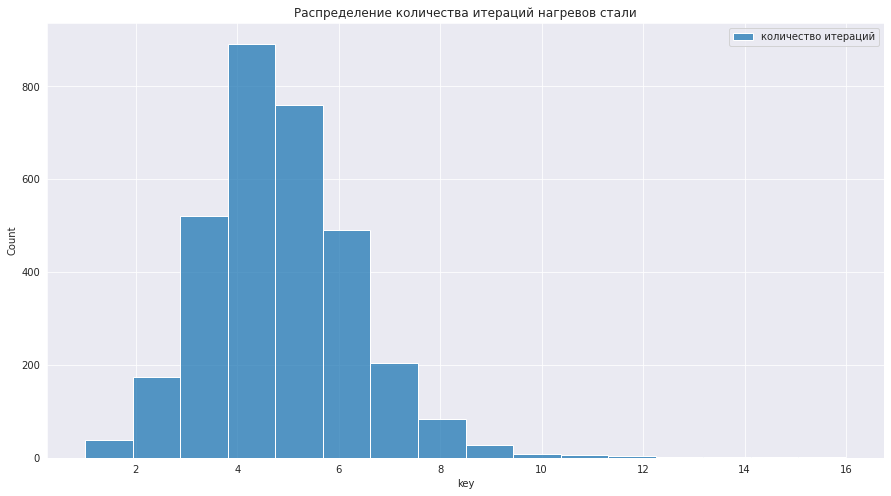

In [56]:
figure = plt.figure(figsize=(15,8))
sns.histplot(data_dict['data_arc']['key'].value_counts(), bins=16, label = 'количество итераций')
plt.title('Распределение количества итераций нагревов стали')
plt.legend();

Итак, гистограмма напоминает своей формой нормальное распределение чуть вытянутое в правую сторону.

Становится очевидно, что чаще всего при проведении процедуры обработки стали производится не более 6 итераций нагрева, однако, в некоторых случаях это значение может достигать 15-16 раз.

### Анализ активной и реактивной мощностей для нагрева

Перейдем к анализу мощностей. Вспомним, что по информации от заказчика есть сильноотрицательное значение мощности, которое точно является аномалией. Проверим показатели активной и реактивной мощностей на наличие отрицательных значений.

In [57]:
data_dict['data_arc'].query('active_power<0 or reactive_power<0')

,key,begin,end,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Итак, мы нашли всего один выброс с отрицательным значением реактивной мощности, судя по всему это ошибка измерения или какой-либо сбой в технологическом процессе. В любом случае, избавимся от этой аномалии, удалив данные о партии 2116 из набора данных.

In [58]:
outlier_keys = data_dict['data_arc'].query('active_power<0 or reactive_power<0')['key'].to_list()
print('Количество записей для удаления:', data_dict['data_arc'].query('key.isin(@outlier_keys)').shape[0])
data_dict['data_arc'] = data_dict['data_arc'].query('~key.isin(@outlier_keys)')

Количество записей для удаления: 4


Теперь построим диаграмму размаха для активной и реактивной мощности.

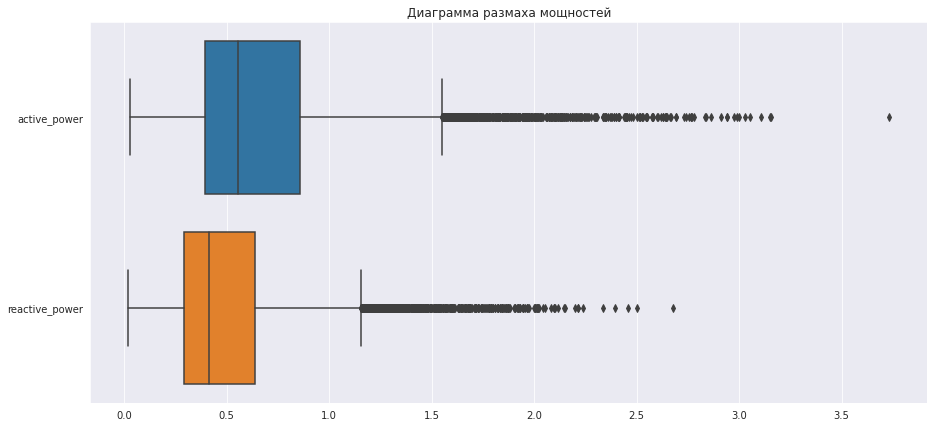

In [59]:
figure = plt.figure(figsize=(15,7))
sns.boxplot(data=data_dict['data_arc'][['active_power','reactive_power']], orient='h')
plt.title('Диаграмма размаха мощностей');

Диаграммы размаха, построенные для активной и реактивной мощности говорят нам о том, что медианное значение реактивной мощности меньше медианного значения активной мощности, а также размер межквартильного интервала для реактивной мощности меньше, что говорит о более плотном распределении характерном для этого вида мощности. Оба распределения вытянуты вправо.

#### Расчёт полной мощности

Часть полной мощности, которую удалось передать в нагрузку за период переменного тока, называется активной мощностью.

Мощность, которая не была передана в нагрузку, а привела к потерям на нагрев и излучение, называется реактивной мощностью.

Полная же мощность определяется по формуле:

$$
S = \sqrt{P^2 + Q^2},\\где\ S - полная\ мощность,\\P - активная\ мощность,\\Q - реактивная\ мощность
$$

Рассчитаем полную мощность и добавим информацию о ней в наш датасет.

In [60]:
data_dict['data_arc']['full_power'] = (data_dict['data_arc']['active_power']**2 + \
                                       data_dict['data_arc']['reactive_power']**2)**0.5

Изобразим на графике плотность распределения средних значений по партии трёх видов мощностей.

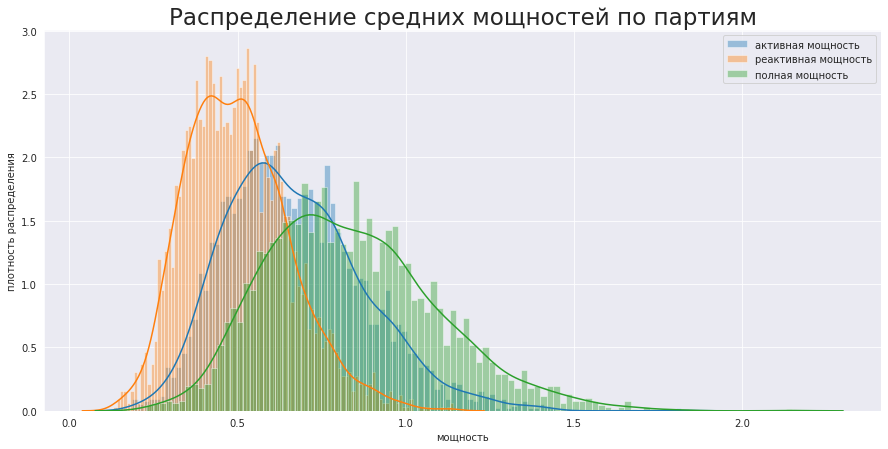

In [61]:
fig, ax = plt.subplots(figsize = (15,7))
sns.distplot(data_dict['data_arc'].groupby('key')['active_power'].mean(), bins=100, label = 'активная мощность', ax=ax)
sns.distplot(data_dict['data_arc'].groupby('key')['reactive_power'].mean(), bins=100, label = 'реактивная мощность', ax=ax)
sns.distplot(data_dict['data_arc'].groupby('key')['full_power'].mean(), bins=100, label = 'полная мощность', ax=ax)
ax.legend()
ax.set_ylabel('плотность распределения')
ax.set_xlabel('мощность')
ax.set_title('Распределение средних мощностей по партиям', fontsize = 23);

Выводы, сделанные для диаграммы размаха активной и реактивной мощностей, уместны и для этого графика. Все три распределения вытянуты вправо, т.е. имеют разброс в сторону увеличения значения, наибольшая плостность распределения значений характерна для реактивной мощности, наименьшая - для полной мощности.

### Вычисление  продолжительности нагрева

Добавим в данные о нагреве столбец с продолжительностью нагрева в секундах.

In [62]:
data_dict['data_arc']['duration'] = data_dict['data_arc'].end - data_dict['data_arc'].begin
data_dict['data_arc']['duration'] = data_dict['data_arc']['duration'].apply(lambda x: x.total_seconds())

Выведем на экран первые 5 строк датасета для проверки добавленных полей

In [63]:
data_dict['data_arc'].head()

,key,begin,end,active_power,reactive_power,full_power,duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0


Построим гистограмму распределения средней продолжительности нагрева по партиям.

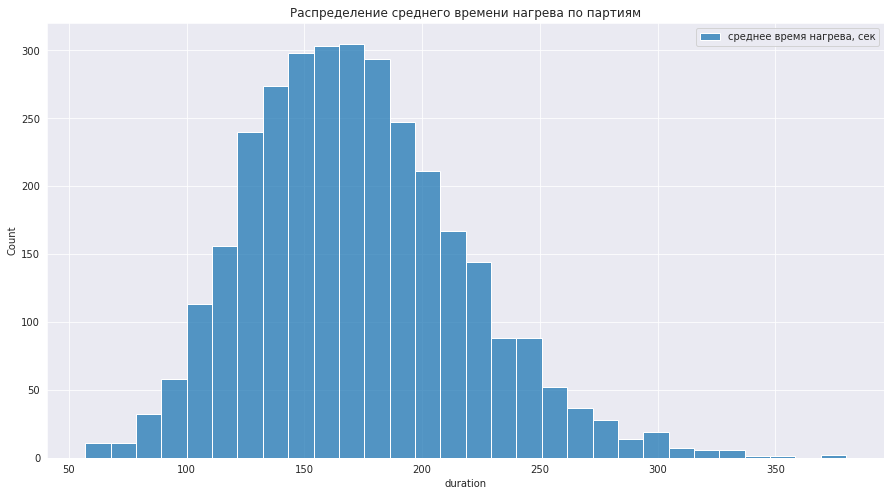

In [64]:
figure = plt.figure(figsize=(15,8))
sns.histplot(data_dict['data_arc'].groupby('key')['duration'].mean(), bins=30, label = 'среднее время нагрева, сек')
plt.title('Распределение среднего времени нагрева по партиям')
plt.legend();

График показывает, что среднее время нагрева чаще всего составляет от 2 до 3 минут, однако, встречаются длительные нагревы более 5 минут, возможно, это говорит об излишнем нагреве стали. 

Построим также диаграмму рассеивания для длительности и мощностей.

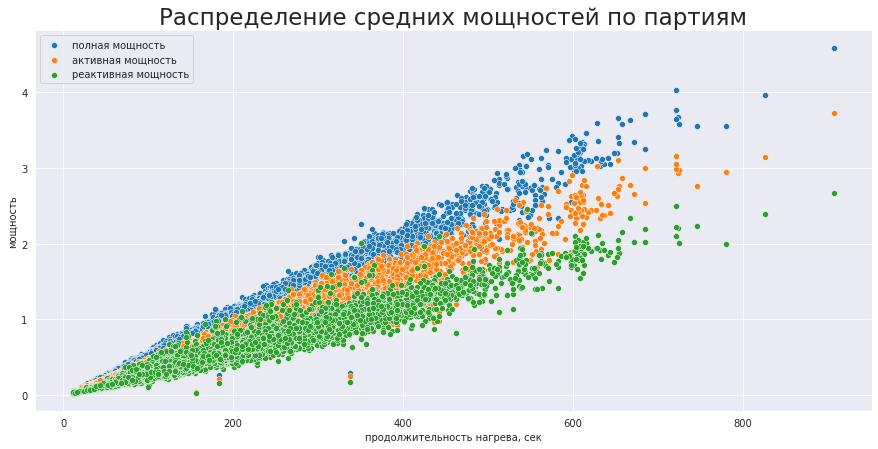

In [65]:
fig, ax = plt.subplots(figsize = (15,7))
sns.scatterplot(data=data_dict['data_arc'], x='duration', y='full_power', label = 'полная мощность', ax=ax)
sns.scatterplot(data=data_dict['data_arc'], x='duration', y='active_power', label = 'активная мощность', ax=ax)
sns.scatterplot(data=data_dict['data_arc'], x='duration', y='reactive_power', label = 'реактивная мощность', ax=ax)
ax.legend()
ax.set_ylabel('мощность')
ax.set_xlabel('продолжительность нагрева, сек')
ax.set_title('Распределение средних мощностей по партиям', fontsize = 23);

По данному графику мы можем сделать вывод о наличии ярковыраженной положительной линейной взаимосвязи между продолжительностю нагрева и величной всех типов мощности - чем больше время нагрева, тем больше мощность. 

При дальнейшем корреляционном анализе нужно будет обратить внимание на коэффициенты корреляции данных признаков и не допустить передачи в линейную модель признаков с высоким коэффициентом корреляции.

### Анализ добавления сыпучих веществ, проволоки и газа

Построим диаграммы размаха для наборов данных о добавлении сыпучих материалов, проволоки и газа.

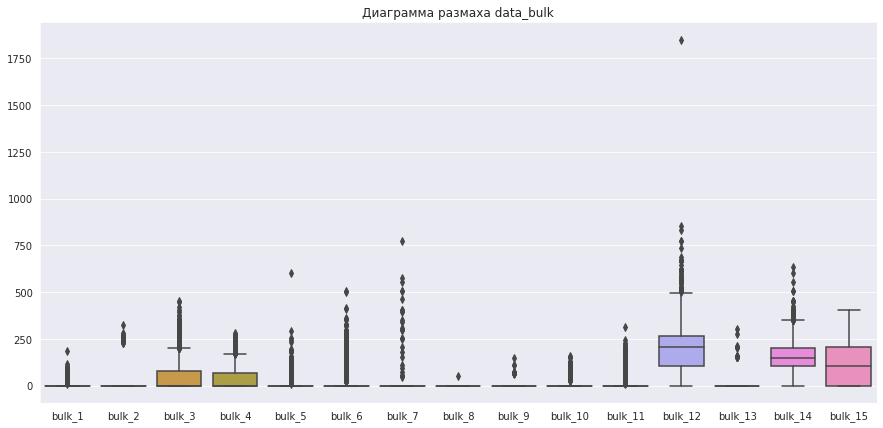

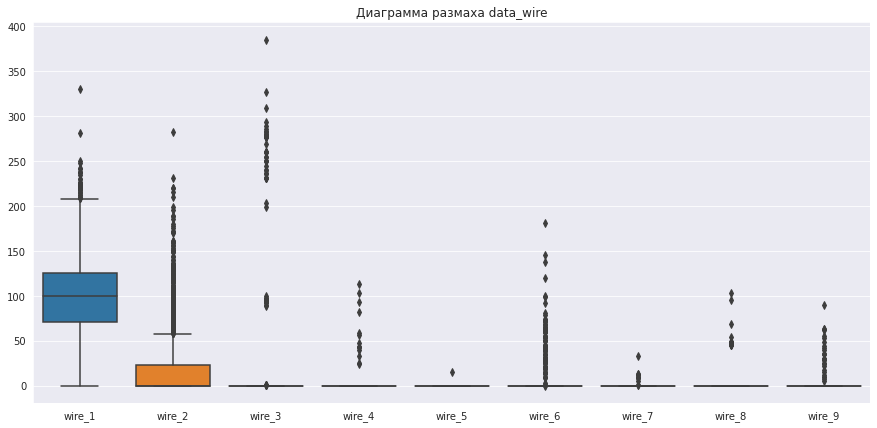

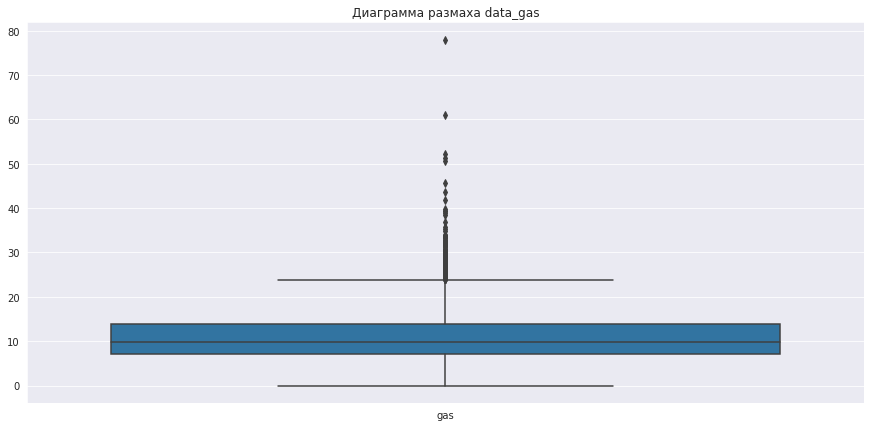

In [66]:
for name in ['data_bulk', 'data_wire', 'data_gas']:
    figure = plt.figure(figsize=(15,7))
    sns.boxplot(data=data_dict[name].set_index('key'), orient='v')
    plt.title(f'Диаграмма размаха {name}');

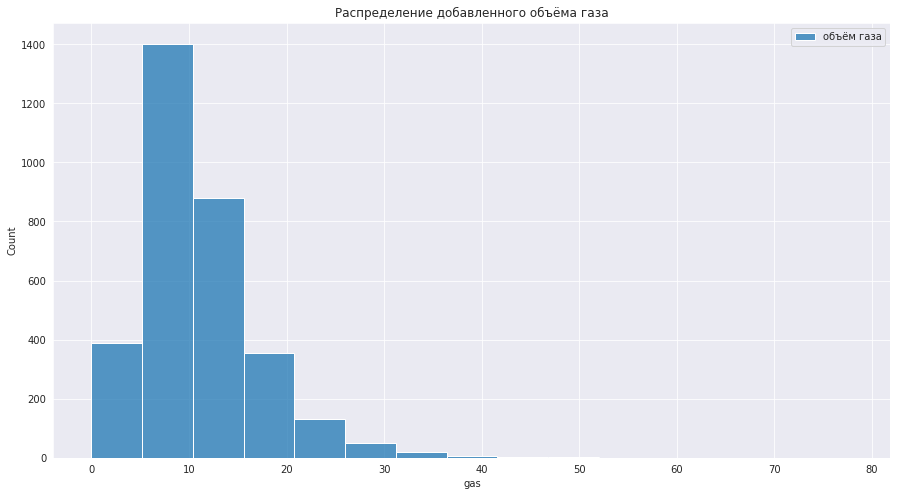

In [67]:
figure = plt.figure(figsize=(15,8))
sns.histplot(data_dict['data_gas']['gas'], bins=15, label = 'объём газа')
plt.title('Распределение добавленного объёма газа')
plt.legend();

На построенных диаграммах мы видим, что чаще всего в процессе обработки стали добавляются сыпучие вещества под номерами 3, 4, 12, 14 и 15, а также проволоки под номерами 1 и 2.

Стоит отметить, что на диаграмме веществ особо смущает одно сильно выбивающееся значение более 1750 для вещества под номером 12.

С помощью диаграммы размаха добавления газа мы видим, что медианой объема добавляемого газа является значение в 10 единиц.

### Анализ измерений температуры стали

Проанализируем распределение первого и последнего измерения температуры стали для каждой партии, для этого построим новый датафрейм, который будет отражать уникальный номер партии и информацию о первом и последнем измерении.

In [68]:
data_temp_fl = data_dict['data_temp'].groupby('key',as_index=False).\
                        agg(first_time=pd.NamedAgg('measurement_time', aggfunc='first'),
                            last_time=pd.NamedAgg('measurement_time', aggfunc='last')).\
merge(data_dict['data_temp'], left_on=['key', 'first_time'], 
                              right_on=['key', 'measurement_time']).drop(['measurement_time'], axis=1).\
rename(columns={'temp':'first_temp'}).\
merge(data_dict['data_temp'], left_on=['key', 'last_time'], 
                              right_on=['key', 'measurement_time']).drop(['measurement_time'], axis=1).\
rename(columns={'temp':'last_temp'})

Посмотрим информацию о полученном датафрейме.

In [69]:
data_temp_fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         3216 non-null   int64         
 1   first_time  3216 non-null   datetime64[ns]
 2   last_time   3216 non-null   datetime64[ns]
 3   first_temp  3216 non-null   float64       
 4   last_temp   2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.8 KB


Мы видим, что данные о значении последнего замера температуры отсутствуют для почти 800 партий.

Отсортируем датасет по убыванию номера партии и выведем первые 10 строк.

In [70]:
data_temp_fl.sort_values(by='key', ascending=False).head(10)

,key,first_time,last_time,first_temp,last_temp
3215,3241,2019-09-01 04:03:30,2019-09-01 04:38:08,1586.0,NaN
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,1617.0,NaN
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,1598.0,NaN
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,1584.0,NaN
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,1569.0,NaN
3210,3236,2019-08-31 22:08:13,2019-08-31 22:31:42,1607.0,NaN
3209,3235,2019-08-31 21:31:47,2019-08-31 22:00:25,1590.0,NaN
3208,3234,2019-08-31 20:54:17,2019-08-31 21:15:28,1614.0,NaN
3207,3233,2019-08-31 20:24:14,2019-08-31 20:47:24,1597.0,NaN
3206,3232,2019-08-31 19:55:53,2019-08-31 20:17:12,1563.0,NaN


Можно предположить, что для последних почти 800 партий произошел сбой в работе измерительного оборудования и финальная температура стали не была зафиксирована. Т.к. финальная температура по цели исследования является для нас целевым признаком, то мы не можем восстановить её значения, т.к. это может существенно исказить результаты исследования, поэтому удалим пустые значения из набора данных.

In [71]:
data_temp_fl = data_temp_fl.dropna().reset_index(drop=True)

Ещё раз выведем информацию о датасете на экран для того, чтобы убедиться в отсутствии пропусков.

In [72]:
data_temp_fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         2477 non-null   int64         
 1   first_time  2477 non-null   datetime64[ns]
 2   last_time   2477 non-null   datetime64[ns]
 3   first_temp  2477 non-null   float64       
 4   last_temp   2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 96.9 KB


Отлично, мы получили данные о первом и последнем замере температуры для почти 2500 партий, теперь мы можем построить их распределение, однако, по информации от заказчика, в данных могут содержаться выбросы по температуре, её значение не может быть меньше 1500 градусов, проверим это и удалим выбросы.

In [73]:
data_temp_fl.query('first_temp<1500 or last_temp<1500')

,key,first_time,last_time,first_temp,last_temp
855,867,2019-06-04 14:21:00,2019-06-04 14:57:17,1191.0,1599.0
1201,1214,2019-06-16 05:32:00,2019-06-16 06:14:45,1208.0,1591.0
1604,1619,2019-06-30 11:03:54,2019-06-30 11:21:54,1218.0,1590.0
2036,2052,2019-07-21 14:51:40,2019-07-21 15:24:06,1227.0,1592.0


Итак, мы нашли всего 4 выброса со значением первоначальной температуры менее 1500 градусов, судя по всему это ошибка измерения или какой-либо сбой в технологическом процессе. В любом случае, избавимся от этой аномалии, удалив данные об этих 4 партиях из набора данных.

In [74]:
outlier_keys_temp = data_temp_fl.query('first_temp<1500 or last_temp<1500')['key'].to_list()
print('Количество записей для удаления:', data_temp_fl.query('key.isin(@outlier_keys_temp)').shape[0])
data_temp_fl = data_temp_fl.query('~key.isin(@outlier_keys_temp)')

Количество записей для удаления: 4


Мы избавились от выбросов в данных и можем переходить к построению графика распределений температур.

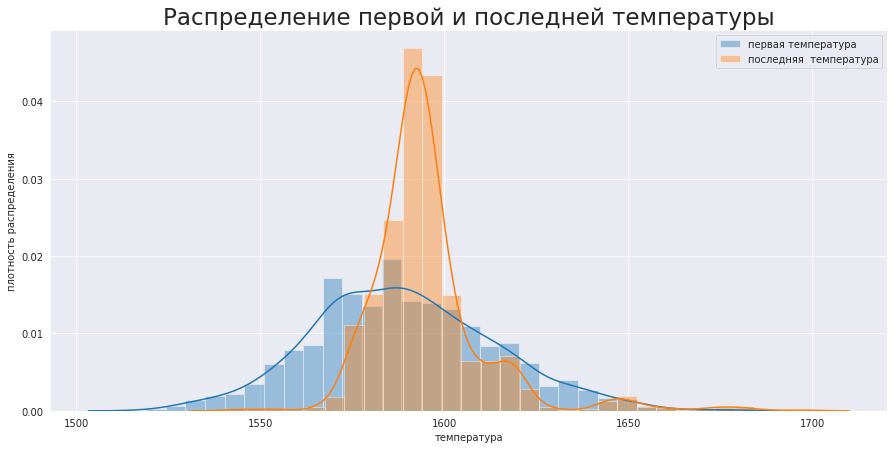

In [75]:
fig, ax = plt.subplots(figsize = (15,7))
sns.distplot(data_temp_fl['first_temp'], bins=30, label = 'первая температура', ax=ax)
sns.distplot(data_temp_fl['last_temp'], bins=30, label = 'последняя  температура', ax=ax)
ax.legend()
ax.set_ylabel('плотность распределения')
ax.set_xlabel('температура')
ax.set_title('Распределение первой и последней температуры', fontsize = 23);

Данный график показывает, что распределения первого и последнего значения температуры имеют форму нормального распределения, плотность распределения последней температуры более высокая, как и её среднее значение около 1600 градусов, можно предположить, что в большинстве случаев значение итоговой температуры около 1600 градусов является наиболее оптимальным для процесса обработки стали.

### Список партий для дальнешего исследования

На этапе ознакомления с данными, мы заметили, что количество партий в разных датасетах различно, для дальнейшего исследования, выделения признаков и обучения моделей, нам необходимо, чтобы для каждого эксперимента была информация обо всех доступных параметрах, поэтому выделим список уникальных номеров партий, информация о которых содержится одновременно во всех наборах данных. Вместо набора данных о температуре `data_temp` будем использовать информацию из вырожденного датасета `data_temp_fl`, т.к. информация из этого датасета отфильтрована по отсутствию пропусков и аномалий в данных.

In [76]:
keys_list = set(data_temp_fl['key'].values)
for name, df in data_dict.items():
    if name != 'data_temp':
        keys_list = keys_list & set(df['key'].values)
    else:
        pass
keys_list = list(keys_list)    
print('Количество партий для проведения дальнейшего исследования:', len(keys_list))

Количество партий для проведения дальнейшего исследования: 2324


**Промежуточные выводы:** мы провели этап исследовательского анализа данных, выявили и избавились от аномалий в данных по температуре (4 партии) и мощности при нагреве (1 партия). 

Также нами были рассчитаны и добавлены в датасет, содержащий информацию о нагреве данных, два дополнительных признака: полная мощности и продолжительность нагрева. Мы выявили, что полная мощность и продолжительность нагрева находятся в прямой линейной зависимости, на следующем этапе нам будет необходимо проверить наличие мультиколлинеарности между этими признаками, т.к. её наличие может сказаться отрицательным образом на этапе обучения модели линейной регрессии. 

Также мы узнали, что чаще всего для нагрева стали достаточно 4-6 итераций, при этом исходя из распределения финальной температуры, судя по всему, оптимальной величиной показателя является значение около 1600 градусов.

Средняя продолжительность итерации нагрева составляет от 2 до 3 минут.

Чаще всего в процессе обработки стали добавляются сыпучие вещества под номерами 3, 4, 12, 14 и 15, а также проволоки под номерами 1 и 2.

Медианой объема добавляемого газа является значение в 10 единиц.

Также нами был сформирован датасет первого и последнего измерения температуры для каждой партии. Мы выявили, что для около 800 последних партий отсутствует информация о финальном замере температуры, стоит обратить на это внимание заказчика для проверки измерительных приборов.

Мы сформировали список из уникальных номеров партий, информация о которых, содержится во всех датасетах одновременно, дальнейшее исследование мы будем проводить для этих партий.

Исследовательский анализ данных завершен, можно переходить к этапу выделения и отбора признаков.

## Подготовка данных к обучению

### Выделение признаков

Для того, чтобы мы могли передать данные в модель для обучения, перед этим нам нужно провести последние преобразования и объединить всё в один датасет.

В первую очередь нам нужно сгруппировать данные из источника `data_arc` до уровня уникального номера партии. Предлагается агрегировать суммарную продолжительность нагрева и средние значения мощностей.

In [77]:
data_arc_grouped = data_dict['data_arc'].\
                    groupby('key',as_index=False).agg({'duration':'sum',
                                                       'full_power':'mean',
                                                       'active_power':'mean',
                                                       'reactive_power':'mean'})

In [78]:
data_arc_grouped.head()

,key,duration,full_power,active_power,reactive_power
0,1,1098.0,1.165279,0.975629,0.636648
1,2,811.0,0.912304,0.763150,0.499528
2,3,655.0,0.597907,0.505176,0.319815
3,4,741.0,0.953741,0.802313,0.515074
4,5,869.0,1.008939,0.836793,0.563161


Теперь вспомним о том, что в некоторых таблицах у нас остаются поля типа `datetime `, которые мы не сможем передать в модель, это таблицы `data_bulk_time` и `data_wire_time` - их мы полностью удалим, а из таблицы с выделенной начальной и финальной температурами удалим поля `first_time` и `last_time`.

In [79]:
data_temp_fl = data_temp_fl.drop(['first_time', 'last_time'],axis=1)
del data_dict['data_bulk_time']
del data_dict['data_wire_time']

Заменим в данные о замерах температуры и нагревах на сгруппированные датасеты в общем словаре с датасетами.

In [80]:
data_dict['data_arc'] = data_arc_grouped
data_dict['data_temp'] = data_temp_fl

Ещё раз удостоверимся, что в наших итоговых данных везде уникальный номер партии и нет пропусков.

In [81]:
for name, df in data_dict.items():
    print('—'*80, '\nДатасет ', name,'\n','—'*80 ,sep='')
    print('Check NA:', df.isna().any(axis=1).sum())
    print('Check KEY duplicated values:', df['key'].duplicated().sum())
    print('Size of dataset:', df.shape)

————————————————————————————————————————————————————————————————————————————————
Датасет data_arc
————————————————————————————————————————————————————————————————————————————————
Check NA: 0
Check KEY duplicated values: 0
Size of dataset: (3213, 5)
————————————————————————————————————————————————————————————————————————————————
Датасет data_bulk
————————————————————————————————————————————————————————————————————————————————
Check NA: 0
Check KEY duplicated values: 0
Size of dataset: (3129, 16)
————————————————————————————————————————————————————————————————————————————————
Датасет data_gas
————————————————————————————————————————————————————————————————————————————————
Check NA: 0
Check KEY duplicated values: 0
Size of dataset: (3239, 2)
————————————————————————————————————————————————————————————————————————————————
Датасет data_temp
————————————————————————————————————————————————————————————————————————————————
Check NA: 0
Check KEY duplicated values: 0
Size of dataset: (2473, 3)
—

Мы удостоверились, что в наши данные готовы к объединению, теперь мы можем объединить данные из всех датасетов в один набор данных `data_total` по уникальному номеру партии, который содержится в составленном нами ранее списке `keys_list`.

In [82]:
i_prev = ''
for i in data_dict.keys():
    if i_prev == '':
        data_total = data_dict[i].query('key.isin(@keys_list)')
    else:
        data_total = data_total.merge(data_dict[i].query('key.isin(@keys_list)'))
    i_prev = i

In [83]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2324 non-null   int64  
 1   duration        2324 non-null   float64
 2   full_power      2324 non-null   float64
 3   active_power    2324 non-null   float64
 4   reactive_power  2324 non-null   float64
 5   bulk_1          2324 non-null   float64
 6   bulk_2          2324 non-null   float64
 7   bulk_3          2324 non-null   float64
 8   bulk_4          2324 non-null   float64
 9   bulk_5          2324 non-null   float64
 10  bulk_6          2324 non-null   float64
 11  bulk_7          2324 non-null   float64
 12  bulk_8          2324 non-null   float64
 13  bulk_9          2324 non-null   float64
 14  bulk_10         2324 non-null   float64
 15  bulk_11         2324 non-null   float64
 16  bulk_12         2324 non-null   float64
 17  bulk_13         2324 non-null   f

Избавимся от столбца `key`, т.к. он не выполняет функцию признака я нужен был для объединения данных.

In [84]:
data_total = data_total.drop('key',axis=1)

In [85]:
data_total.shape

(2324, 31)

Итак, теперь мы можем сказать, что для дальнейшего исследования нам доступна информация о 30 признаках и 1 целевом признаке за 2324 наблюдения.

### Корреляционный анализ и отбор признаков

Построим корреляционную матрицу парных коэффициентов корреляции Пирсона для выявления взаимосвязей между признаками.

<Figure size 1080x1080 with 0 Axes>

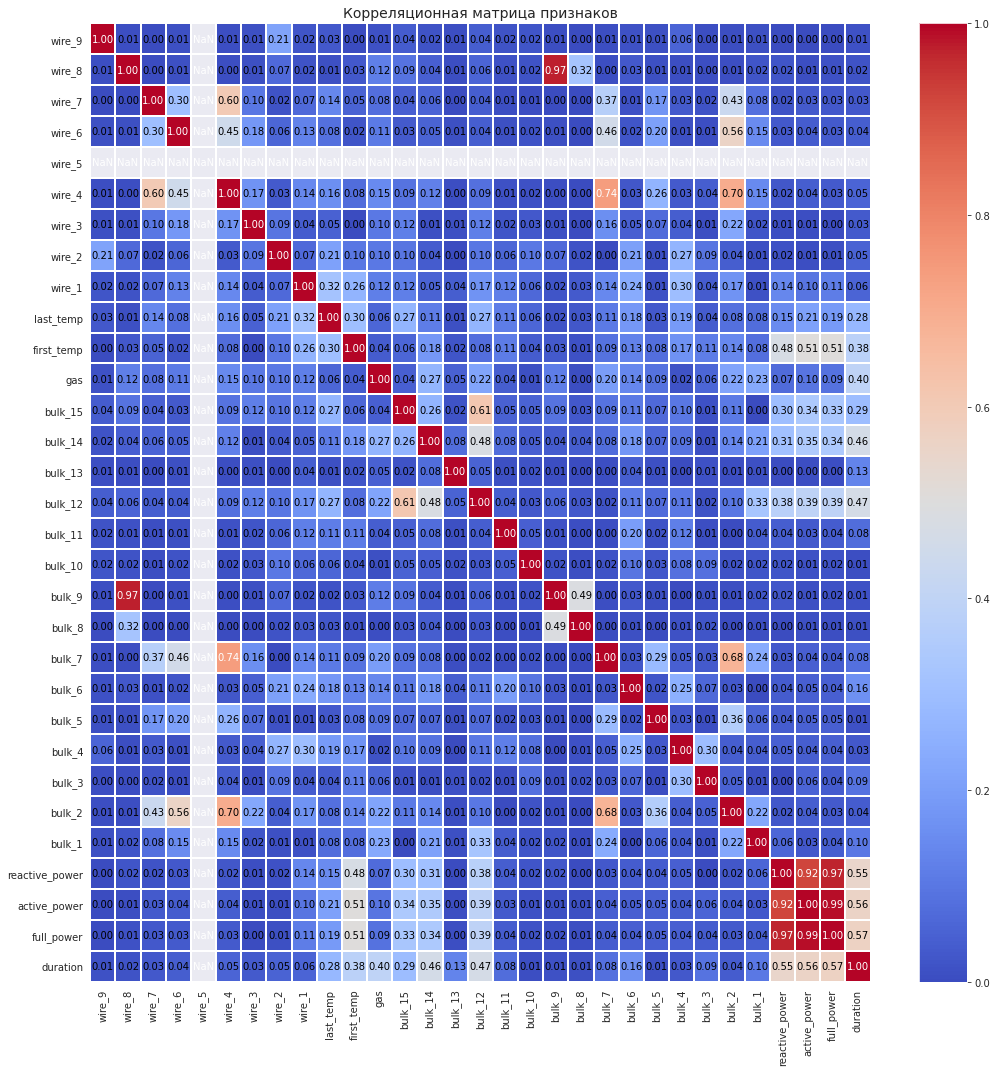

In [86]:
corr = abs(data_total.corr())
plt.figure(figsize=(15,15))
plot_correlation_matrix(corr.values, 
                        x_labels=corr.columns, 
                        y_labels=corr.index, 
                        vmin=0, vmax=1, color_map='coolwarm', 
                        title='Корреляционная матрица признаков', 
                        fontsize_factor=1, 
                        figsize=(15, 15))
plt.tight_layout();

На основании корреляционной матрицы мы наблюдаем сильную линейную взаимосвязь между показателями мощностей, а также между показателями `bulk_9` и `wire_8`, что говорит о наличии мультиколлинеарности между данными признаками. Возможно в соответствии с технологическим процессом эти вещества всегда добавляются вместе.

Сама по себе мультиколлинеарность не несёт в себе вреда, но её наличие может негативно сказаться на обучении простых линейных моделей, более сложные же модели, вроде деревьев решений или градиентного бустинга, в свою очередь устойчивы к наличию  мультиколлинеарности между признаками.

Таким образом, мы принимаем решение, что в дальнейшем исследовании из данных, подаваемых на обучение в модель линейной регрессии, мы удалим признаки `full_power` и `reactive_power`, а также вместо признаков `bulk_9` и `wire_8` добавим признак с их суммой.

Обратим также внимание на признак `wire_5`, в изначальном наборе данных в этом признаке было заполнено только одно единственное значение, очевидно, что этот вид проволоки используется крайне редко, и в процессе наших преобразований данных наблюдение с использованием этого вещества было отброшено. Удалим этот признак.

In [87]:
data_total.drop('wire_5', axis=1, inplace=True)

Обратим также внимание на взаимосвязи целевого признака `last_temp` с остальными признаками. Сильных линейных связей не наблюдается, наибольшие значения коэффициента корреляции 0.2-0.3 характерны для признаков начальной температуры, продолжительности нагрева и активной мощности, а также веществ `wire1`, `wire_2`, `bulk_12`, `bulk_15`.

## Обучение

### Выделение тренировочной и тестирующей выборки

С помощью функции `train_test_split` разделим наш датасет на обучающую и тестовую выборку, в которую выделим 25% наблюдений.

In [88]:
features_train, features_test, target_train, target_test = \
        train_test_split(data_total.drop('last_temp', axis=1), 
                         data_total['last_temp'],
                         test_size=0.25, 
                         random_state=RANDOM_STATE)
print('Размер обучающей выборки:',features_train.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])

Размер обучающей выборки: 1743
Размер тестовой выборки: 581


### Обучение моделей

#### Наивная модель

В первую очередь создадим наивную модель регрессии, которая будет предсказывать среднее значение целевого признака, для проверки будущих моделей на адекватность.

In [89]:
dummy_model = DummyRegressor()
dm_mae = abs(cross_val_score(dummy_model, 
                             features_train, 
                             target_train, 
                             cv=CV_COUNT, 
                             scoring='neg_mean_absolute_error').mean())
print('Средняя абсолютная ошибка для наивной модели:', dm_mae)

cv_result = {'dummy': dm_mae}

Средняя абсолютная ошибка для наивной модели: 8.24505765302296


Итак, теперь мы понимаем, что если предсказывать температуру по среднему значению за предыдущие наблюдения, то такая модель будет ошибаться в среднем на 8.24 градуса. Посмотрим, какие предсказания будут давать более сложные модели, начнём с модели линейной регрессии.

#### Модель линейной регрессии

Перед обучением модели линейной регрессии заменим признаки `wire_8` и `wire_9` на признак с их суммой, а также удалим признаки `full_power` и `reactive_power` в связи с наличием мультиколлинеарности.

In [90]:
features_train_lr = features_train.copy()
features_train_lr['w8_b9'] = features_train_lr[['wire_8', 'bulk_9']].sum(axis=1)
features_train_lr = features_train_lr.drop(['wire_8', 'bulk_9', 'full_power', 'reactive_power'], axis=1)

Также для модели линейной регрессии важен масштаб признаков, применим `MinMaxScaler` для масштабирования, и поместим в `Pipeline`.

In [91]:
pipe_lr = Pipeline([('scaler', MinMaxScaler()), 
                    ('regr', LinearRegression())])

Рассчитаем значение метрики MAE для модели линейной регрессии на обучающей выборке с помощью функции `cross_val_score`.

In [92]:
lr_mae = abs(cross_val_score(pipe_lr, 
                             features_train_lr, 
                             target_train, 
                             cv=CV_COUNT, 
                             scoring='neg_mean_absolute_error').mean())
print('Средняя абсолютная ошибка для наивной модели:', lr_mae)

cv_result['LinearRegression'] = lr_mae

Средняя абсолютная ошибка для наивной модели: 6.221016264393766


Итак, обученная модель линейной регрессии ошибается в среднем на 6.22 градуса, это лучше, чем наивная модель, предсказывающая среднее значение предыдущих наблюдений. Посмотрим, какие результаты покажут более сложные модели.

#### Модели решающих деревьев и градиентного бустинга

Поместим в итерируемый объект типа словарь виды моделей и их параметры, для дальнейшего использования в цикле.

In [93]:
estimators = {'CBR': {'estimator': CatBoostRegressor(random_seed=RANDOM_STATE,
                                                     loss_function='MAE',
                                                     verbose=False),
                      'params': {'learning_rate': [0.01, 0.9],
                                 'depth': [5, 100],
                                 'iterations': [10, 5000]}},
              'DTR': {'estimator': DecisionTreeRegressor(random_state=RANDOM_STATE),
                      'params':  {'min_samples_split': [2, 10],
                                  'max_depth': [2, 100],
                                  'min_samples_leaf': [2, 100]}},
              'RFR':{'estimator': RandomForestRegressor(random_state=RANDOM_STATE),
                     'params':  {'min_samples_split': [2, 10],
                                 'max_depth': [2, 100],
                                 'min_samples_leaf': [2, 100]}}
             }

Переберем модели с различными значениями гиперпараметров с использованием `RandomizedSearchCV`, запомним данные модели с наименьшим значением метрики `MAE`.

In [94]:
best_score = 1000
best_params = {}
best_estimator = None

for model_name, est in estimators.items():
    estimator = est['estimator']
    params = est['params']
    
    grid_search = RandomizedSearchCV(estimator, 
                                     params, 
                                     scoring='neg_mean_absolute_error', 
                                     cv=CV_COUNT, 
                                     random_state=RANDOM_STATE, 
                                     n_jobs=-1)
    grid_search.fit(features_train,target_train)
    score = abs(grid_search.best_score_)
    cv_params = grid_search.best_params_
    
    print(f'MAE модели {model_name} с лучшими параметрами:', score)
    print(f'Лучшие параметры модели {model_name}:', cv_params) 
    
    cv_result[model_name] = score
    
    if best_score > score:
        best_score = score
        best_estimator = grid_search.best_estimator_
        best_params = cv_params


print('-' * 120)
print(f'Наилучшая метрика MAE {best_score} достигнута с помощью модели {best_estimator}')
print('-' * 120)

MAE модели CBR с лучшими параметрами: 6.03444353639964
Лучшие параметры модели CBR: {'learning_rate': 0.01, 'iterations': 5000, 'depth': 5}
MAE модели DTR с лучшими параметрами: 7.343775440576117
Лучшие параметры модели DTR: {'min_samples_split': 2, 'min_samples_leaf': 100, 'max_depth': 100}
MAE модели RFR с лучшими параметрами: 6.328981966379651
Лучшие параметры модели RFR: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 100}
------------------------------------------------------------------------------------------------------------------------
Наилучшая метрика MAE 6.03444353639964 достигнута с помощью модели <catboost.core.CatBoostRegressor object at 0x7f4395649dc0>
------------------------------------------------------------------------------------------------------------------------


Итак, в результате перебора моделей `CatBoostRegressor`, `DecisionTreeRegressor`, `RandomForestRegressor`  и их гиперпараметров, используя технику кросс-валидации, мы получили модель типа `CatBoostRegressor`, дающую минимальное значение метрики `MAE` около 6 градусов.

## Выбор и тестирование модели

### Выбор и тестирование

Мы обучили различные типы моделей и оценивали их качество с помощью кросс-валидации, посмотрим на сводный результат.

In [95]:
pd.DataFrame(cv_result, index=['MAE']).T.sort_values(by='MAE')

,MAE
CBR,6.034444
LinearRegression,6.221016
RFR,6.328982
DTR,7.343775
dummy,8.245058


Все обученные модели прошли проверку на адекватность, значение полученной метрики `MAE` превышает значение метрики, рассчитанное для наивной модели, предсказывающей среднее значение.

Также все модели, кроме модели `DecisionTreeRegressor`, проходят по минимальной границе метрики `MAE` установленной заказчиком в 6,8 градусов.

Наилучший же результат показала модель `CatBoostRegressor`, именно она и будет использована для проведения дальнейшего тестирования модели.

In [96]:
mae_test = mean_absolute_error(target_test, best_estimator.predict(features_test))
print('Средняя абсолютная ошибка выбранной модели для тестовой выборки:', round(mae_test,2))

Средняя абсолютная ошибка выбранной модели для тестовой выборки: 5.56


Выбранную модель `CatBoostRegressor`, обученную для прогнозирования финальной температуры стали после процесса обработки, можно считать качественной и успешной.

### Оценка важности признаков

В качестве заключительного этапа посмотрим на то, какие признаки обладают наибольшим весом влияния в обученной нами модели.

In [97]:
x_importance = pd.DataFrame({'feature_importance': best_estimator.\
                                                           get_feature_importance(Pool(features_train,target_train)), 
                                   'feature_names': features_train.columns}).\
                            sort_values(by=['feature_importance'], ascending=False)

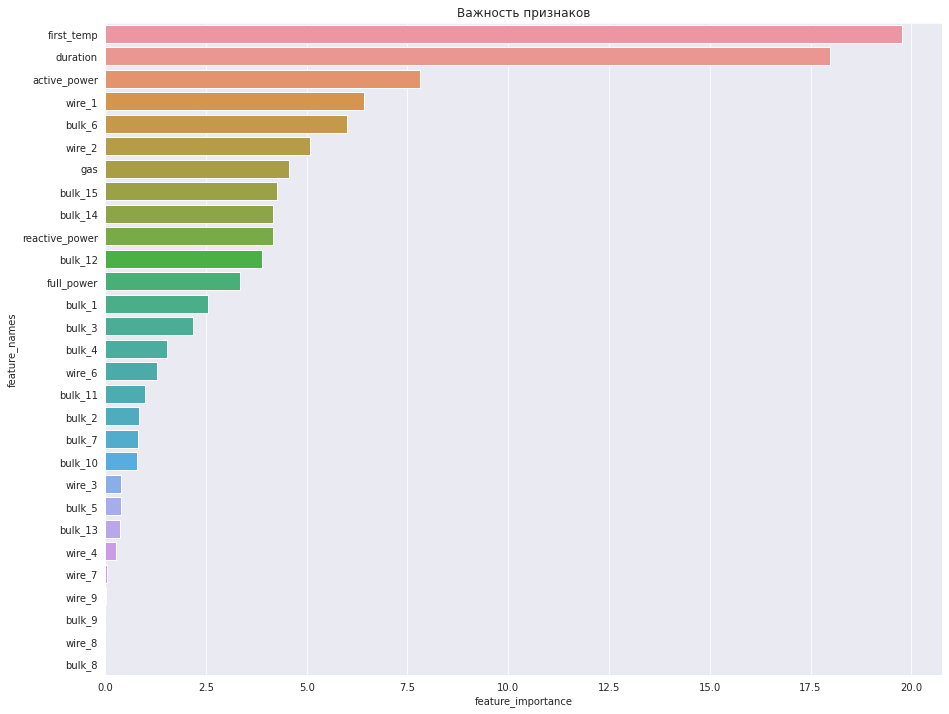

In [98]:
figure = plt.figure(figsize=(15,12))
sns.barplot(data=x_importance, x='feature_importance', y='feature_names', orient='h')
plt.title('Важность признаков');

Итак, наибольшее влияние на температуру стали после обработки оказывают начальная температура перед началом нагрева и суммарная продолжительность нагрева, а также активная мощность электродов в процессе нагрева.

Также вещества `wire_1` и `bulk_6` имеют высокий уровень значимости для определения целевого признака итоговой температуры.

<font color='steelblue'>Я правильно понимаю, что последним пунктом должен быть Отчёт, который по сути будет содержать широкие и развернутые результаты и выводы по всей работе? Обычно я этот пункт называю выводы)</font>

## Отчёт

*Цель исследования заключалась в построении модели, предсказывающей итоговую температуру стали после прохождения процесса обработки в установке типа печь-ковш на основании сопутствующих параметров. Качество построенных моделей оценивалось с помощью метрики `MAE` (среднее абсолютное отклонение) - модель должна ошибаться в среднем не более, чем на 6,8 градусов.*


В ходе исследования мы загрузили и ознакомились с 7 предоставленными наборами данных, обратили внимание на то, что каждый датасет имеет различную размерность, провели первичную предобработку, а именно привели названия столбцов к единой стилистике именования, заменили пропуски, выполнили преобразования типов данных, а также проверили данные на отсутствие дубликатов.

На этапе проведения *исследовательского анализа данных*, нами были выявлены аномалии:
 * температура вещества менее 1500. Согласно данным [Википедии](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C#%D0%A4%D0%B8%D0%B7%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D1%81%D0%B2%D0%BE%D0%B9%D1%81%D1%82%D0%B2%D0%B0) температура плавления стали составляет 1450-1520 °C, таким образом, полученные значения менее 1500 °C для 4 партий были помечены нами как аномалии и удалены из набора данных. Данные показания могут быть связаны либо со сбоем измерительных приборов, либо с нарушением технологического процесса.
 * отрицательное значение реактивной мощности. В одной из партий было обнаружено сильноотрицательное значение реактивной мощности, мы также посчитали, что это могло быть связано с ошибкой измерительного прибора и удалили данные об этой партии из набора данных для дальнейшего исследования.

Также нами были рассчитаны и добавлены в набор данных, содержащий информацию об итерациях нагрева, два дополнительных признака: полная мощность (на основании активной и реактивной мощности) и продолжительность нагрева (на основании времени начала и окончания итераций нагрева).

Также мы узнали, что чаще всего для нагрева стали достаточно 4-6 итераций, при этом исходя из распределения финальной температуры, судя по всему, оптимальной величиной показателя является значение около 1600 градусов.

Средняя продолжительность итерации нагрева составляет от 2 до 3 минут.

Чаще всего в процессе обработки стали добавляются сыпучие вещества под номерами 3, 4, 12, 14 и 15, а также проволоки под номерами 1 и 2.

Медианой объема добавляемого газа является значение в 10 единиц.

Также нами был сформирован набор данных, содержаший информацию о результатах первого и последнего измерения температуры для каждой партии. Мы выявили, что для 739 из 3216 партий отсутствует информация о финальном замере температуры, причём это характерно именно для последних партий, рекомендуем заказчику провести ревизию измерительных приборов.

Мы сформировали список из уникальных номеров партий, для которых информация отражена в полном объеме во всех источниках данных,  для которых проводили дальнейшее исследование, всего 2324 партии.

Следующим этапом мы провели *подготовку данных для обучения моделей*:
* из набора данных, содержащего информацию об итерациях нагрева, вывели суммарную продолжительность нагрева, а также средние значения мощностей для каждой уникальной партии;
* для наблюдений, обладающих полным набором характеристик, собрали всю информацию в общий датасет
* построили матрицу парных коэффициентов корреляции Пирсона для выявления наличия линейных зависимостей между признаками. На основании корреляционной матрицы было выявлено наличие сильной линейной взаимосвязи между показателями мощностей, а также между показателями `bulk_9` и `wire_8`. Возможно, в соответствии с технологическим процессом эти вещества всегда добавляются вместе. Для проволоки `wire_5` в изначальном наборе данных было заполнено только одно единственное значение, очевидно, что этот вид проволоки используется крайне редко, мы обнаружили, что в процессе преобразований данных наблюдение с использованием этого вещества было отброшено, таким образом, мы удалили этот признак. Признаков, обладающих сильной линейной связью с финальной температурой, выявлено не было.

Таким образом, для дальнейшего исследования нами было отобрано и сгенерировано всего 29 признаков, характеризующих процесс обработки стали, и один целевой признак - финальная температура - для 2324 наблюдений.

Далее мы перешли к этапу *обучения моделей*. Сначала мы разделили данные на тренировочную (обучающую) и тестовую (для проверки качества итоговой модели) выборки, выделив 25% данных для теста, размер обучающей выборки составил 1743 наблюдения, тестовой - 581.

Перед обучением основных моделей нами была обучена константная модель, предсказывающая среднее значение итоговой температуры на основании предыдущих наблюдений, для проверки будущих моделей на адекватность. Значение средней абсолютной ошибки (`MAE`) для константной модели составило более 8 градусов.

Для этапа обучение моделей были выбраны следующие типы моделей:

* модель линейной регрессии
* `CatBoostRegressor` -  модель, использующая алгоритм градиентного спуска
* линейная регрессия
* дерево решений
* алгоритм случайный лес

Стоит отметить, что модель линейной регрессии является чувствительной к наличию мультиколлинеарности (тесные линейные связи) между признаками, а также к различному масштабу в значениях признаков, поэтому для обучения этой модели мы убрали признаки полной и реактивной мощности, а также провели масштабирование значений признаков.

Подбор оптимальных гиперпараметров и расчёт целевой метрики средней абсолютной ошибки прогнозирования (`MAE`) производились с помощью кросс-валидации для каждой модели.

Также для каждой модели производился замер скорости процедуры кросс-валидации, обучения и предсказания.

Для *итогового выбора модели* была сформирована таблица с результатами рассчёта целевой метрики на кросс-валидации

In [99]:
pd.DataFrame(cv_result, index=['MAE']).T.sort_values(by='MAE')

,MAE
CBR,6.034444
LinearRegression,6.221016
RFR,6.328982
DTR,7.343775
dummy,8.245058


Таким образом, моделью, показавшей наилучший результат предсказаний, была выбрана модель вида `CatBoostRegressor` с шагом обучения 0.01, количеством итераций 5000 и глубиной 5, показавшая минимальное значение, среди рассмотренных моделей, среднего абсолютного отклонения целевого признака в 6 градусов.

Данная модель была *протестирована* на тестовой выборке и показала значение метрики 5.56 градусов, т.е. выбранная модель допускает ошибку прогнозирования в среднем на 5.56 градусов, при том, что максимально допустимое значение метрики, обозначенное бизнесом, было указано 6,8.

Наиболее *важными признаками* для модели оказались начальная температура вещества, продолжительность нагрева и активная мощность нагревающих электродов. 

Таким образом, помимо всего прочего, для снижения затрат на электроэнергию, а также для увеличения КПД нагревательных элементов, можно порекомендовать предприятию ООО «Так закаляем сталь» рассмотреть возможность проведения мероприятий по компенсации возникающей реактивной мощности в электросетях.